# COMPACT REG BENCHMARK 

### 1. PARSE AND LOAD RESULTS

In [62]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt

sns.set_context("talk")
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/"


# load families summary
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.dataset == "homfam"]
families = summary_homfam.drop(["subset", "file", "min_length", "max_length", "perc_ref_total", "dataset"], axis = 1)

In [63]:
score_files = glob.glob(os.path.join(data_dir, "evaluation/score/*regressive_comp_analysis*"))
gap_files = glob.glob(os.path.join(data_dir, "evaluation/gaps/*regressive_comp_analysis*totGap"))
trace_files = glob.glob(os.path.join(data_dir, "compact_benchmark/*/*/.command.trace"))

In [64]:
# 1. PREP SCORES
def get_scores(score_files): 
    def parse_score(score_file): 
        return(pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1))

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:4]
    scores.columns = ['name', 'sp', 'tc', 'column']
    #scores.name = scores.name.str.split(".", expand = True)[:-1]
    scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = scores.name.str.split(".", expand = True)
    scores = scores.drop("method", axis = 1)
    return(scores)

# 2. PREP GAPS 
def get_gaps(files): 
    def parse_gaps(gap_file): 
        gaps = pd.read_csv(gap_file, header = None)
        gaps["name"] = os.path.splitext(os.path.basename(gap_file))[0]
        return(gaps)
    gaps = pd.concat(list(map(parse_gaps, files)))
    gaps.columns = ['gaps', 'name']
    return(gaps)

# 3. PREP TRACES
def get_traces(files): 
    def parse_trace(trace):
        f = os.path.basename(os.path.dirname(trace))
        df = pd.read_csv(trace, sep = "=").T
        df["name"] = f
        return(df.reset_index().drop("index", axis = 1))
    
    df = pd.concat(list(map(parse_trace, files)))
    df = df[["name", "realtime", "vmem"]]
    return(df)

# COMPUTE
scores = get_scores(score_files)
gaps = get_gaps(gap_files)
traces = get_traces(trace_files)

# MERGE ALL STATS
stats = scores.merge(gaps, on = "name")
stats = stats.merge(traces, on = "name")

# and add families info 
stats = stats.merge(families, on = "family")

In [65]:
stats["size_group"] = pd.Categorical(stats.size_group, ["small", "medium", "large", "xlarge"])

In [66]:
stats["bucket_size"] = stats.bucket_size.astype(int) 

In [67]:
stats["align_method"] = pd.Categorical(stats.align_method, ["expand", "compact", "quickcompact"])

In [68]:
stats_filtered = stats[stats.family.isin(list(stats[stats.align_method == "quickcompact"].family))]
stats_filtered = stats[stats.size_group.isin(["large", "xlarge"])]

### 2. ANALYSIS

#### 1. SANITY CHECK: Does compact produce alignments with fewer gaps? 

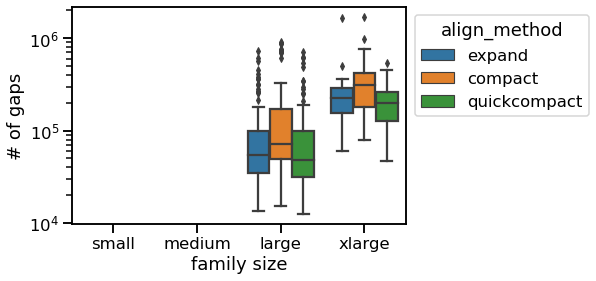

In [73]:

ax = sns.boxplot(data=stats_filtered, x="size_group", y="realtime", hue="align_method")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='family size', ylabel='# of gaps')
plt.yscale('log')


In [ ]:
ax = sns.boxplot(data=stats_filtered, x="size_group", y="gaps", hue="align_method")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='family size', ylabel='# of gaps')
plt.yscale('log')


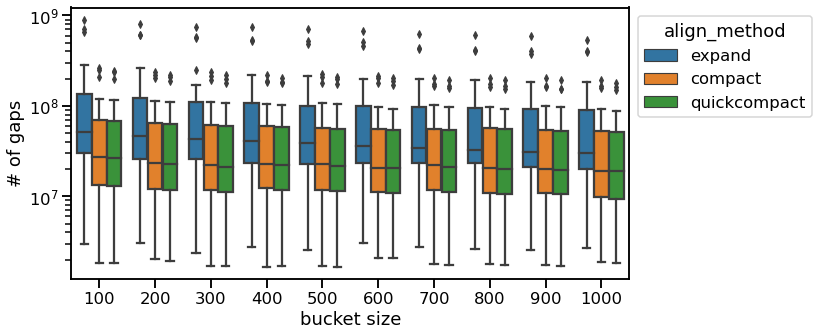

In [70]:
# here on the large only 
plt.figure(figsize=(10,5))

ax = sns.boxplot(data=stats_filtered, x="bucket_size", y="gaps", hue="align_method")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='bucket size', ylabel='# of gaps')
plt.yscale('log')

[Text(0.5, 0, 'bucket size')]

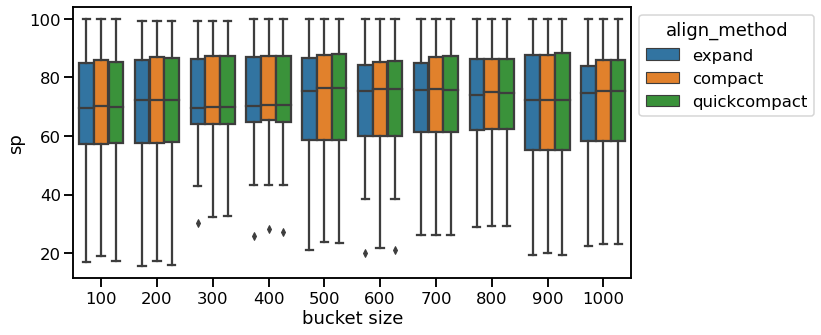

In [71]:
# here on the large only 
plt.figure(figsize=(10,5))

ax = sns.boxplot(data=stats_filtered, x="bucket_size", y="sp", hue="align_method")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='bucket size')


[Text(0.5, 0, 'bucket size')]

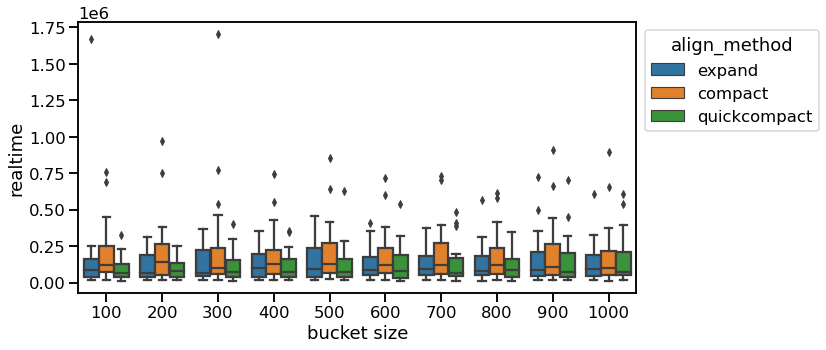

In [72]:
# here on the large only 
plt.figure(figsize=(10,5))

ax = sns.boxplot(data=stats_filtered, x="bucket_size", y="realtime", hue="align_method")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='bucket size')


In [7]:
# Plot with dots and family size 
# Number of gaps 
# Heatmap 

#### Table with average across families 

In [55]:
table_pooled = stats_filtered.groupby([ "align_method"], as_index = False).agg(
    sp_mean=('sp',"mean"),
    #sp_variance=('sp', "var"),    
    tc_mean=('tc',"mean"),
    #tc_variance=('tc', "var"), 
    gaps_mean=('gaps',"mean"),
    time_mean=('realtime',"mean"),
    #time_variance=('realtime', "var")
)
table_pooled

,align_method,sp_mean,tc_mean,gaps_mean,time_mean
0,expand,71.1910,43.7775,1.301698e+08,140442.405
1,compact,71.4750,43.4775,5.357586e+07,206043.060
2,quickcompact,71.4625,43.4990,5.124614e+07,125312.500


In [56]:
table_pooled = stats.groupby(["align_method"], as_index = False).agg(
    sp_mean=('sp',"mean"),
    tc_mean=('tc',"mean"),
    gaps_mean=('gaps',"mean"),
    time_mean=('realtime',"mean"),
)
table_pooled

,align_method,sp_mean,tc_mean,gaps_mean,time_mean
0,expand,81.248404,57.916277,3.227990e+07,52974.745745
1,compact,81.498723,58.058617,1.438022e+07,73780.058511
2,quickcompact,71.863235,43.977941,5.024812e+07,123079.127451


In [20]:
table_pooled = stats_xlarge.groupby(["bucket_size", "align_method"], as_index = False).agg(
    sp_mean=('sp',"mean"),
    tc_mean=('tc',"mean"),
    gaps_mean=('gaps',"mean"),
    time_mean=('realtime',"mean"),
)
table_pooled

,bucket_size,align_method,sp_mean,tc_mean,gaps_mean,time_mean
0,100,compact,64.066667,24.200000,1.158561e+08,362145.166667
1,100,expand,63.750000,24.100000,3.422154e+08,430318.833333
2,200,compact,67.733333,27.066667,1.053929e+08,383260.833333
3,200,expand,67.450000,27.100000,3.029779e+08,208053.666667
4,300,compact,67.933333,25.233333,1.044262e+08,560472.000000
5,300,expand,67.750000,25.216667,2.871332e+08,210238.833333
6,400,compact,68.416667,28.350000,9.569780e+07,304944.333333
7,400,expand,68.033333,28.700000,2.702615e+08,232372.666667
8,500,compact,70.733333,30.650000,9.890124e+07,345844.500000
9,500,expand,70.466667,31.383333,2.621861e+08,232510.666667


# Next questions, what about when using different trees? 
# Is it more resiliant 